In [ ]:
import os
import pandas as pd
import numpy as np
from tkinter import filedialog
import tkinter as tk
from scipy.stats import ttest_ind, f_oneway
import seaborn as sns
import matplotlib.pyplot as plt

# Create a Tkinter root window
root = tk.Tk()
root.withdraw()  # Hide the root window

# Ask user to select the directory containing all replicate folders
#main_directory = filedialog.askdirectory(title="Select Main Directory Containing Replicate Folders")

main_directory = "c:\\Users\\oes6098\\Desktop\\test trackmate\\"

# Check if a directory was selected
if not main_directory:
    print("No directory selected. Exiting...")
    exit()

# Ask the user for the number of conditions
#num_conditions = int(input("Enter the number of conditions: "))
num_conditions = 3

# Ask the user for the name of each condition folder
#condition_names = [input(f"Enter the name of condition {i+1}: ") for i in range(num_conditions)]
condition_names=['wt','27del', '854']

# Ask the user for track duration to filter out
#track_duration_input = int(input("Enter the minimum track duration (sec) you would like (Please enter whole number): "))
track_duration_input = 10

column_titles = ['NUMBER_SPOTS', 'NUMBER_GAPS', 'NUMBER_SPLITS', 'NUMBER_MERGES',
                 'NUMBER_COMPLEX', 'LONGEST_GAP', 'TRACK_START', 'TRACK_STOP', 'TRACK_DISPLACEMENT', 'TRACK_DURATION', 
                 'TRACK_MEAN_SPEED', 'TRACK_MAX_SPEED','TRACK_MIN_SPEED', 'TRACK_MEDIAN_SPEED', 'TRACK_STD_SPEED', 
                 'TRACK_MEAN_QUALITY','TOTAL_DISTANCE_TRAVELED', 'MAX_DISTANCE_TRAVELED', 'CONFINEMENT_RATIO', 
                 'MEAN_STRAIGHT_LINE_SPEED','LINEARITY_OF_FORWARD_PROGRESSION', 'MEAN_DIRECTIONAL_CHANGE_RATE']

# Create a dictionary to hold DataFrames for each condition
df_dict = {condition: {title: pd.DataFrame() for title in column_titles} for condition in condition_names}

# Iterate over each replicate folder
for replicate_folder in os.listdir(main_directory):
    replicate_path = os.path.join(main_directory, replicate_folder)
    
    if not os.path.isdir(replicate_path):
        continue
    
    print(f"Processing replicate: {replicate_folder}")
    
    # Iterate over each condition
    for condition in condition_names:
        condition_path = os.path.join(replicate_path, condition)
        
        if not os.path.isdir(condition_path):
            print(f"Condition folder '{condition}' does not exist in replicate '{replicate_folder}'. Skipping...")
            continue
        
        print(f"  Processing condition: {condition}")
        
        # Iterate over folders in the condition directory
        for folder_idx, folder_name in enumerate(os.listdir(condition_path)):
            folder_path = os.path.join(condition_path, folder_name)
            
            if not os.path.isdir(folder_path):
                continue
            
            # Check if export.csv exists in the folder
            export_csv_path = os.path.join(folder_path, 'export.csv')
            if not os.path.exists(export_csv_path):
                print(f"export.csv not found in folder '{folder_name}'. Skipping...")
                continue
            
            # Read the CSV file into a pandas DataFrame
            df = pd.read_csv(export_csv_path)

            # Convert columns to numeric values
            df[column_titles] = df[column_titles].apply(pd.to_numeric, errors='coerce')

            # Filter rows based on conditions
            filtered_rows = df.loc[(~df[column_titles].isna().any(axis=1)) & (df['TRACK_DURATION'] >= track_duration_input)]

            # Add filtered rows to the respective DataFrames in df_dict as new columns
            for column in column_titles:
                if not filtered_rows[column].isna().all():
                    df_dict[condition][column][f"{replicate_folder}_{folder_name}_data"] = filtered_rows[column].reset_index(drop=True)

# Create the trackmate_results folder in the main directory
trackmate_results_folder = os.path.join(main_directory, 'trackmate_results')
if not os.path.exists(trackmate_results_folder):
    os.makedirs(trackmate_results_folder)

# # Save the raw DataFrames to separate Excel files for each condition with each metric in a different sheet
# for condition, df_group in df_dict.items():
#     with pd.ExcelWriter(os.path.join(trackmate_results_folder, f"{condition}_compiled_raw.xlsx")) as writer:
#         for title, df in df_group.items():
#             print('saving', title, 'to', condition)
#             # Truncate the sheet name if it exceeds 31 characters
#             sheet_name = title[:31] if len(title) > 31 else title
#             df.to_excel(writer, sheet_name=sheet_name, index=False)


# Create a dictionary to hold DataFrames for mean values of each condition
mean_df_dict = {}

# Iterate over each metric title
for title in column_titles:
    # Create an empty DataFrame for the current metric
    mean_df_dict[title] = pd.DataFrame(index=range(500))  # Predefined number of rows
    
    print(f"Calculating mean values for metric: {title}")
    
    # Iterate over each condition
    for condition, df_group in df_dict.items():
        print(f"  Calculating mean values for condition: {condition}")
        
        # Get the DataFrame for the current condition and metric
        df = df_group.get(title)
        
        # Check if the DataFrame exists for the current condition and metric
        if df is not None:
            # Calculate mean values for each column, skipping missing values
            mean_values = df.mean(skipna=True)
            print(f"    Mean values for condition {condition}:")
            print(mean_values)
            
            # Convert mean values to list
            mean_values_list = mean_values.tolist()
            
            # Add NaN values to make the list length equal to 500
            mean_values_list.extend([np.nan] * (500 - len(mean_values_list)))
            
            # Fill in the mean values into the DataFrame
            mean_df_dict[title][condition] = mean_values_list
        else:
            print(f"    No data found for condition {condition} and metric {title}")

# Create a folder for mean results
mean_results_folder = os.path.join(main_directory, 'mean_results')
if not os.path.exists(mean_results_folder):
    os.makedirs(mean_results_folder)

# Save the mean DataFrames to separate Excel files for each metric
for title, mean_df in mean_df_dict.items():
    print(f"Saving mean values for metric: {title}")
    with pd.ExcelWriter(os.path.join(mean_results_folder, f"{title}_mean_values.xlsx")) as writer:
        mean_df.to_excel(writer, index=False)

print("Mean value calculation and saving completed.")





Processing replicate: 1.12.24 Live pVitro 5A +LAMP
  Processing condition: wt
  Processing condition: 27del


C:\Users\oes6098\AppData\Local\Temp\ipykernel_12252\406080825.py:78: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(export_csv_path)


  Processing condition: 854
Processing replicate: 1.17.24 pvitro 5a lamp mscarlet LIVE
  Processing condition: wt


C:\Users\oes6098\AppData\Local\Temp\ipykernel_12252\406080825.py:78: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(export_csv_path)


  Processing condition: 27del
  Processing condition: 854
Calculating mean values for metric: NUMBER_SPOTS
  Calculating mean values for condition: wt
    Mean values for condition wt:
1.12.24 Live pVitro 5A +LAMP_10_data           30.172471
1.12.24 Live pVitro 5A +LAMP_11_data           27.709215
1.12.24 Live pVitro 5A +LAMP_2_data            44.951468
1.12.24 Live pVitro 5A +LAMP_3_data            27.283883
1.12.24 Live pVitro 5A +LAMP_4_data            26.732337
1.12.24 Live pVitro 5A +LAMP_5_data            25.871818
1.12.24 Live pVitro 5A +LAMP_6_data            28.553824
1.12.24 Live pVitro 5A +LAMP_7_data            29.358365
1.12.24 Live pVitro 5A +LAMP_8_data            32.465268
1.12.24 Live pVitro 5A +LAMP_9_data            26.133065
1.17.24 pvitro 5a lamp mscarlet LIVE_1_data    41.598975
1.17.24 pvitro 5a lamp mscarlet LIVE_2_data    29.851491
1.17.24 pvitro 5a lamp mscarlet LIVE_3_data    25.381883
1.17.24 pvitro 5a lamp mscarlet LIVE_4_data    26.841650
1.17.24 pvitro 5a

C:\Users\oes6098\AppData\Local\Temp\ipykernel_12252\406080825.py:193: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  anova_result = f_oneway(mean_df[condition_names[0]].dropna(), mean_df[condition_names[1]].dropna(), mean_df[condition_names[2]].dropna())


Statistical test results saved.


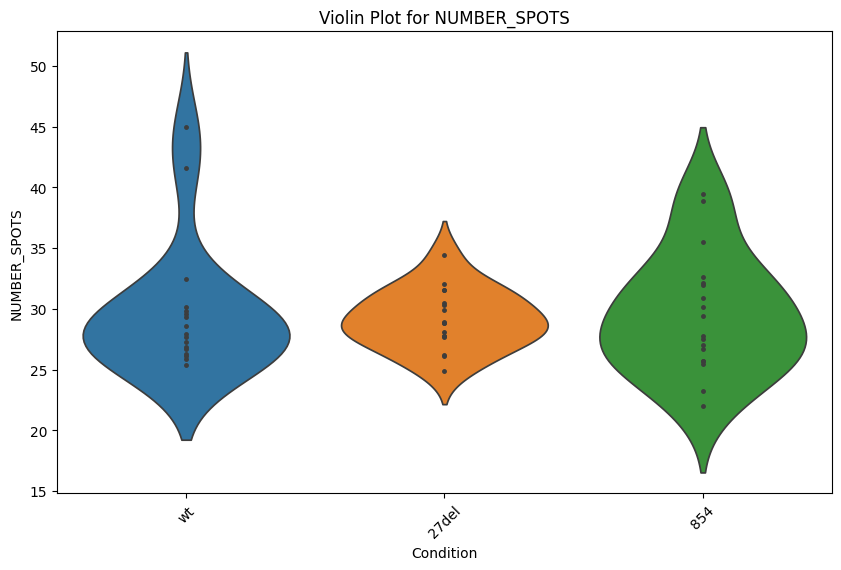

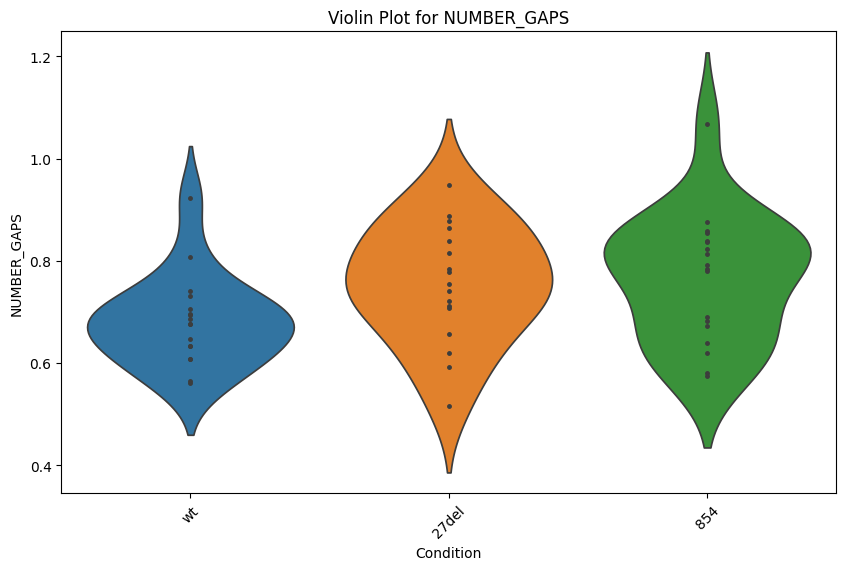

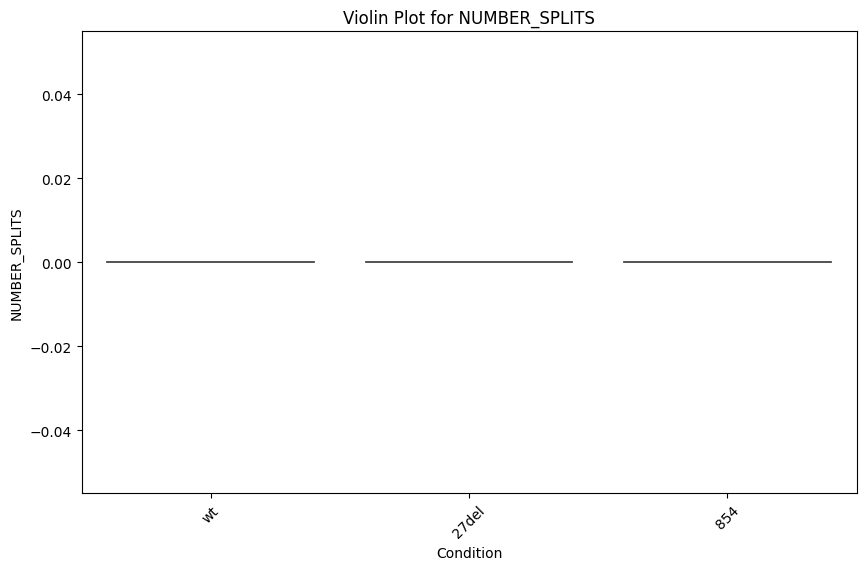

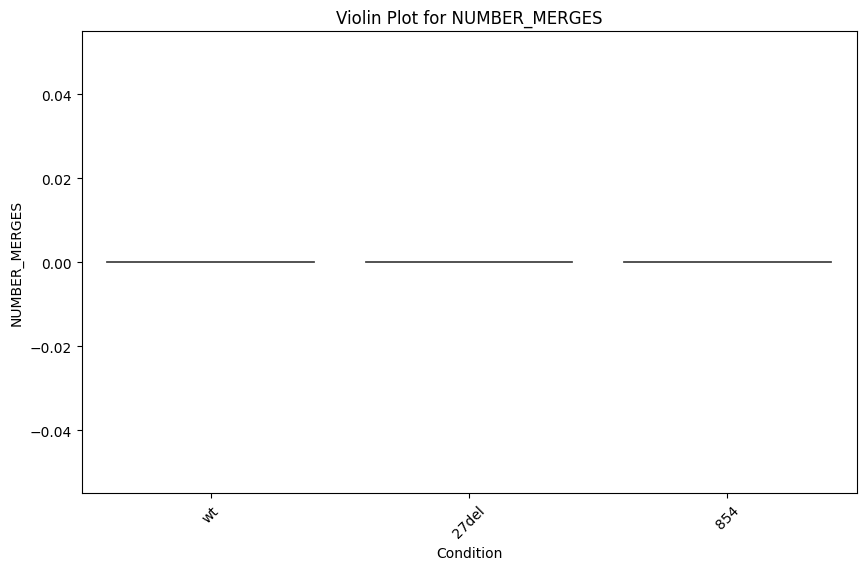

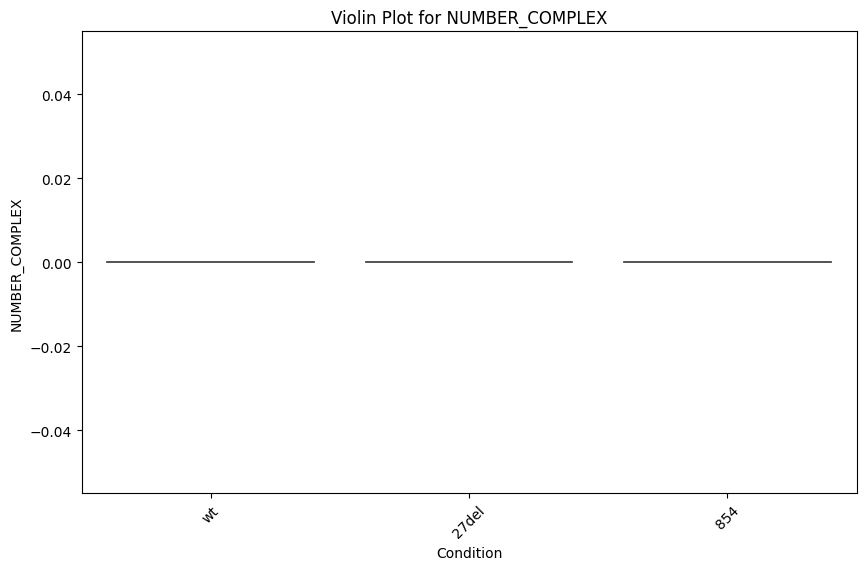

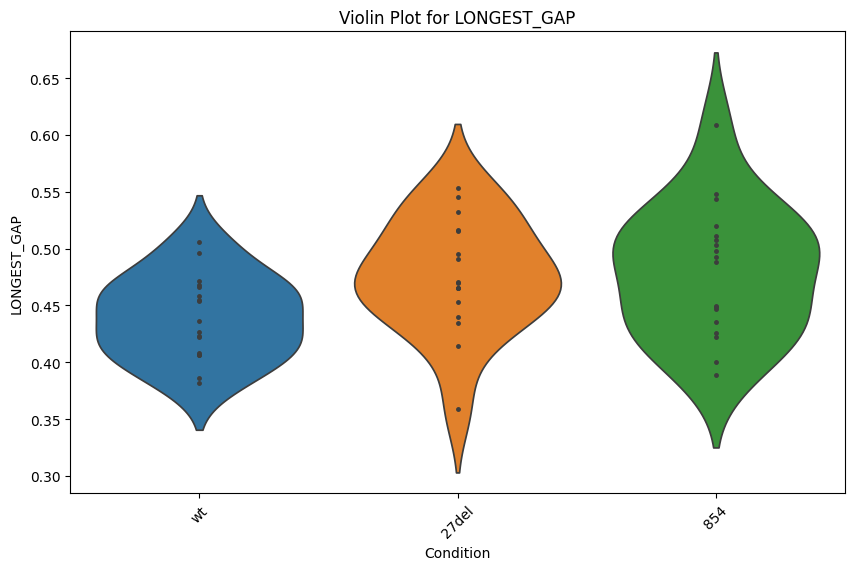

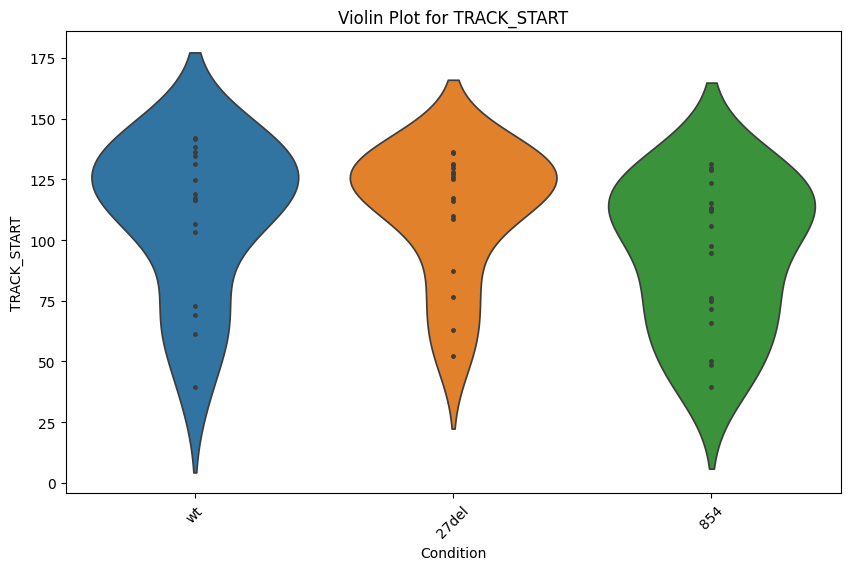

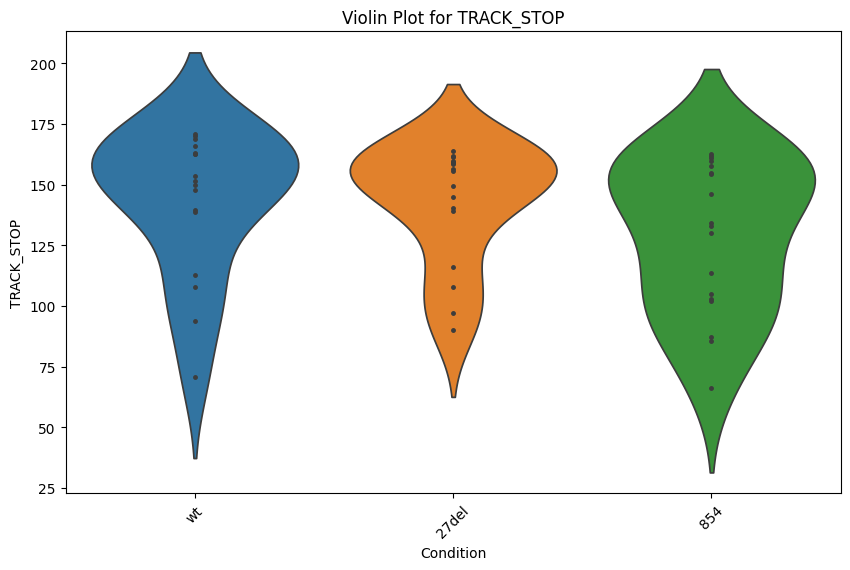

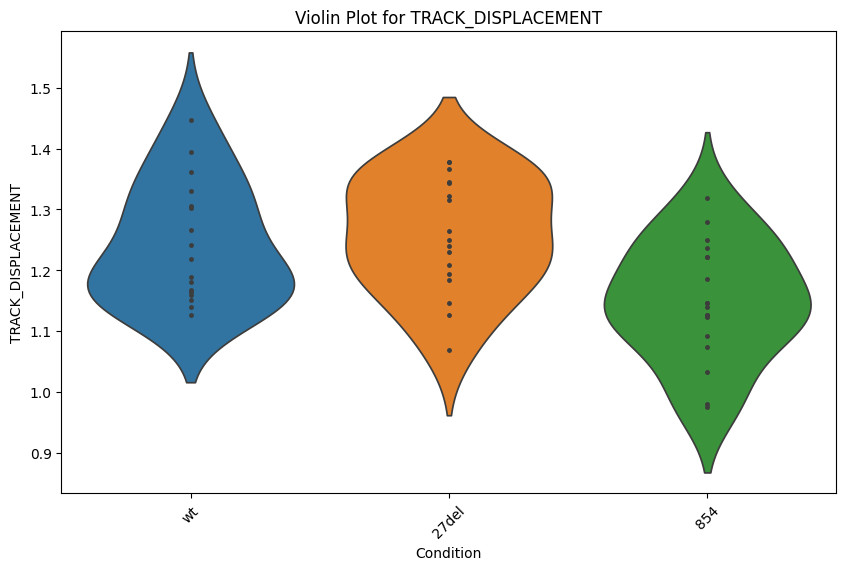

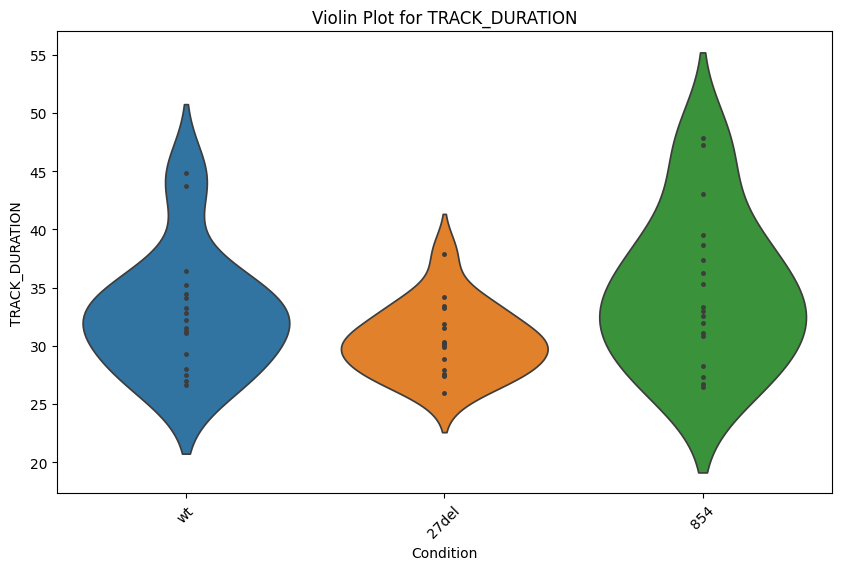

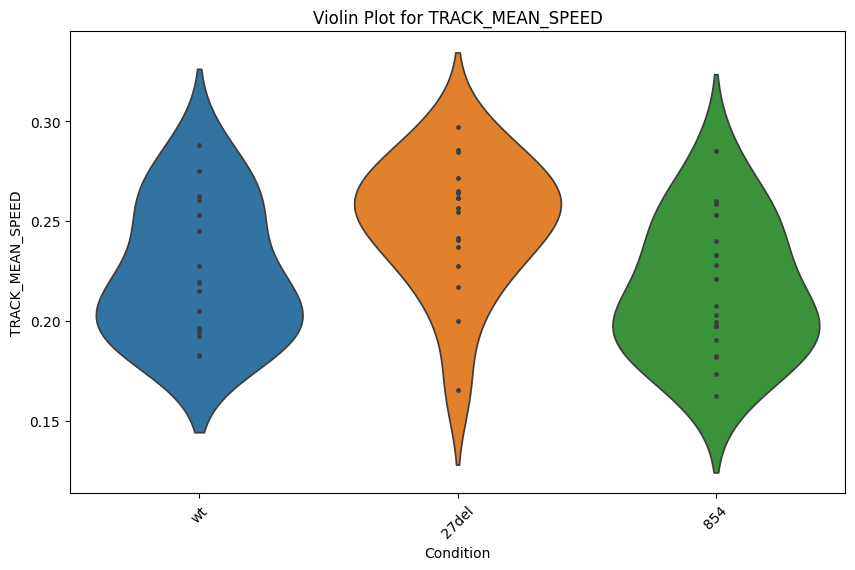

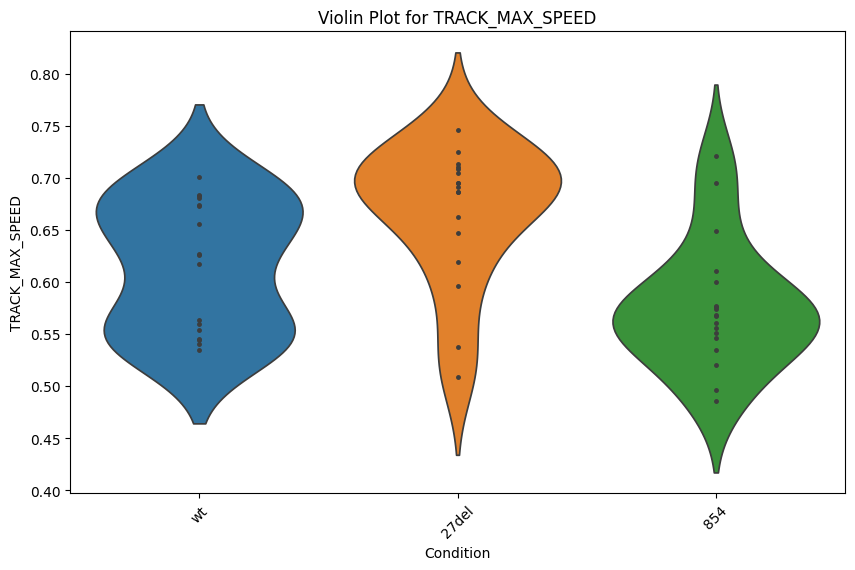

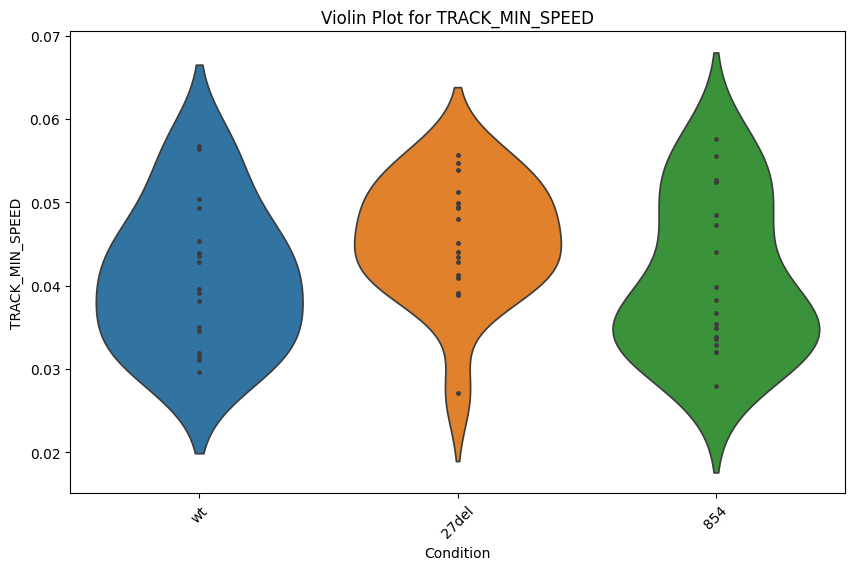

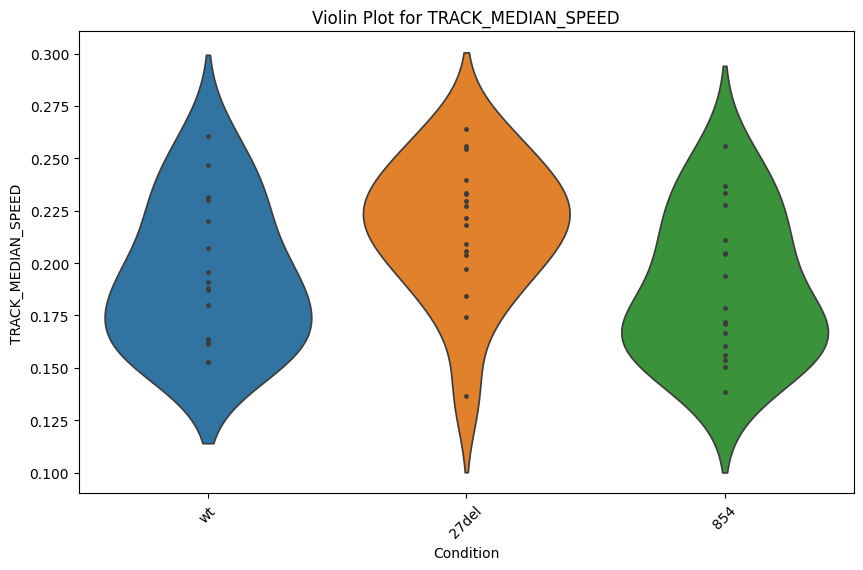

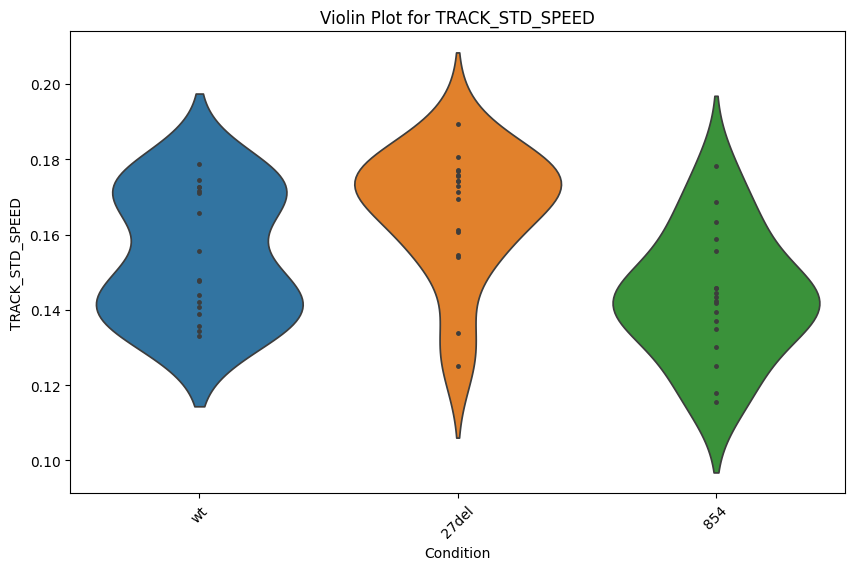

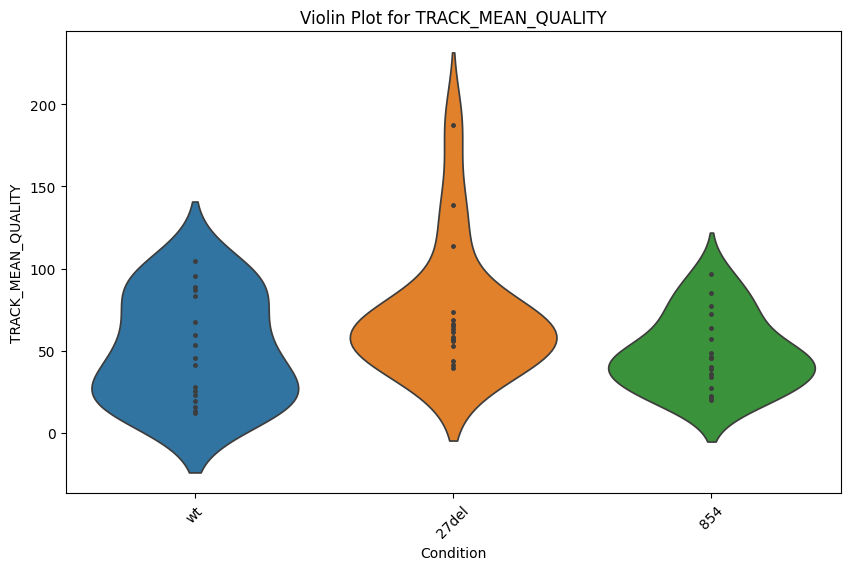

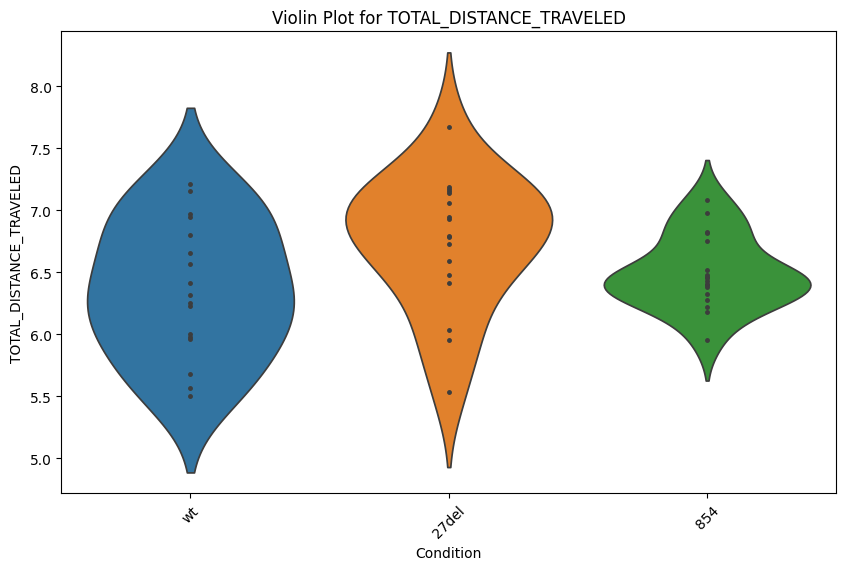

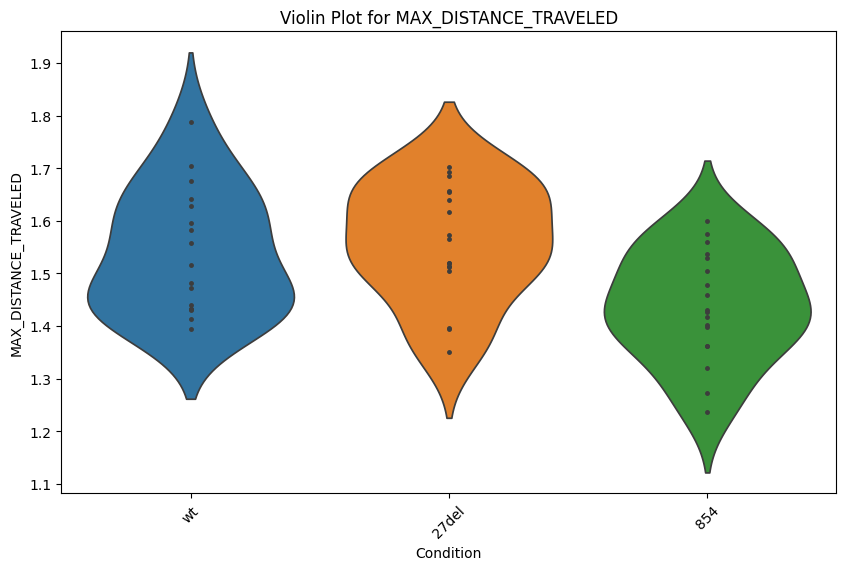

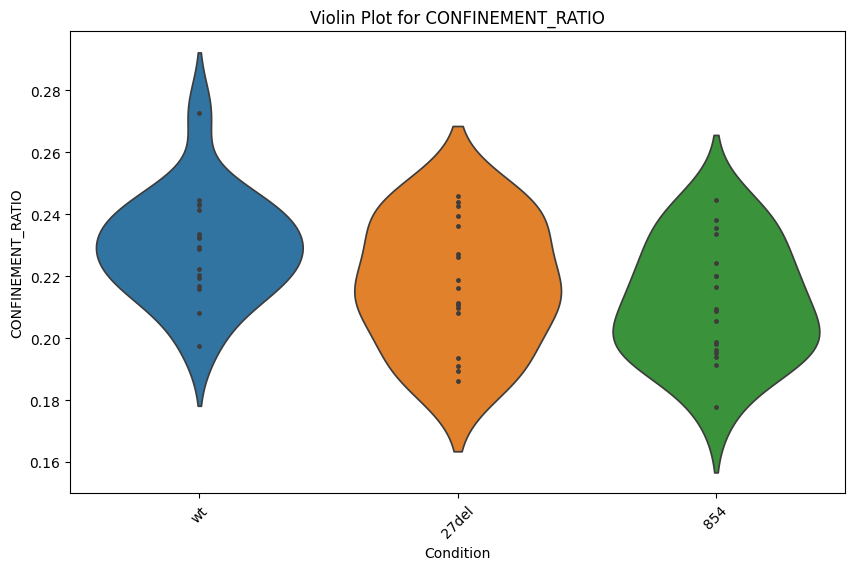

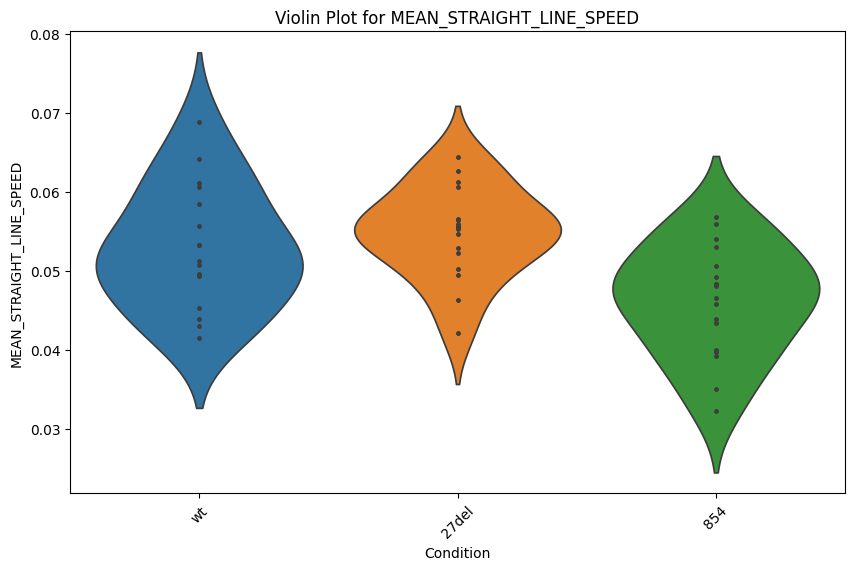

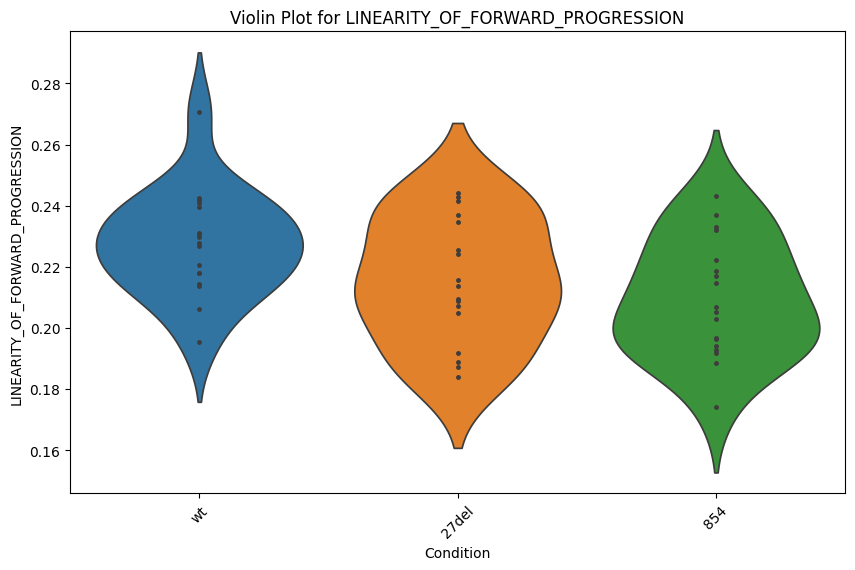

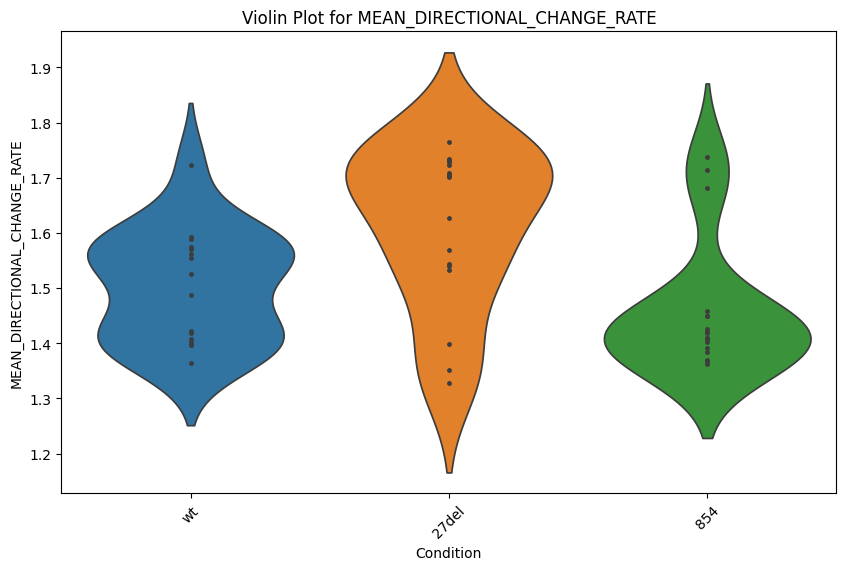

Violin plots saved.


In [5]:
import os
import pandas as pd
import numpy as np
from tkinter import filedialog
import tkinter as tk
from scipy.stats import ttest_ind, f_oneway
import seaborn as sns
import matplotlib.pyplot as plt

# Create a Tkinter root window
root = tk.Tk()
root.withdraw()  # Hide the root window

# Ask user to select the directory containing all replicate folders
#main_directory = filedialog.askdirectory(title="Select Main Directory Containing Replicate Folders")

main_directory = "c:\\Users\\oes6098\\Desktop\\test trackmate\\"

# Check if a directory was selected
if not main_directory:
    print("No directory selected. Exiting...")
    exit()

# Ask the user for the number of conditions
#num_conditions = int(input("Enter the number of conditions: "))
num_conditions = 3

# Ask the user for the name of each condition folder
#condition_names = [input(f"Enter the name of condition {i+1}: ") for i in range(num_conditions)]
condition_names=['wt','27del', '854']

# Ask the user for track duration to filter out
#track_duration_input = int(input("Enter the minimum track duration (sec) you would like (Please enter whole number): "))
track_duration_input = 10

column_titles = ['NUMBER_SPOTS', 'NUMBER_GAPS', 'NUMBER_SPLITS', 'NUMBER_MERGES',
                 'NUMBER_COMPLEX', 'LONGEST_GAP', 'TRACK_START', 'TRACK_STOP', 'TRACK_DISPLACEMENT', 'TRACK_DURATION', 
                 'TRACK_MEAN_SPEED', 'TRACK_MAX_SPEED','TRACK_MIN_SPEED', 'TRACK_MEDIAN_SPEED', 'TRACK_STD_SPEED', 
                 'TRACK_MEAN_QUALITY','TOTAL_DISTANCE_TRAVELED', 'MAX_DISTANCE_TRAVELED', 'CONFINEMENT_RATIO', 
                 'MEAN_STRAIGHT_LINE_SPEED','LINEARITY_OF_FORWARD_PROGRESSION', 'MEAN_DIRECTIONAL_CHANGE_RATE']

# Create a dictionary to hold DataFrames for each condition
df_dict = {condition: {title: pd.DataFrame() for title in column_titles} for condition in condition_names}

# Iterate over each replicate folder
for replicate_folder in os.listdir(main_directory):
    replicate_path = os.path.join(main_directory, replicate_folder)
    
    if not os.path.isdir(replicate_path):
        continue
    
    print(f"Processing replicate: {replicate_folder}")
    
    # Iterate over each condition
    for condition in condition_names:
        condition_path = os.path.join(replicate_path, condition)
        
        if not os.path.isdir(condition_path):
            print(f"Condition folder '{condition}' does not exist in replicate '{replicate_folder}'. Skipping...")
            continue
        
        print(f"  Processing condition: {condition}")
        
        # Iterate over folders in the condition directory
        for folder_idx, folder_name in enumerate(os.listdir(condition_path)):
            folder_path = os.path.join(condition_path, folder_name)
            
            if not os.path.isdir(folder_path):
                continue
            
            # Check if export.csv exists in the folder
            export_csv_path = os.path.join(folder_path, 'export.csv')
            if not os.path.exists(export_csv_path):
                print(f"export.csv not found in folder '{folder_name}'. Skipping...")
                continue
            
            # Read the CSV file into a pandas DataFrame
            df = pd.read_csv(export_csv_path)

            # Convert columns to numeric values
            df[column_titles] = df[column_titles].apply(pd.to_numeric, errors='coerce')

            # Filter rows based on conditions
            filtered_rows = df.loc[(~df[column_titles].isna().any(axis=1)) & (df['TRACK_DURATION'] >= track_duration_input)]

            # Add filtered rows to the respective DataFrames in df_dict as new columns
            for column in column_titles:
                if not filtered_rows[column].isna().all():
                    df_dict[condition][column][f"{replicate_folder}_{folder_name}_data"] = filtered_rows[column].reset_index(drop=True)

# Create the trackmate_results folder in the main directory
trackmate_results_folder = os.path.join(main_directory, 'trackmate_results')
if not os.path.exists(trackmate_results_folder):
    os.makedirs(trackmate_results_folder)

# # Save the raw DataFrames to separate Excel files for each condition with each metric in a different sheet
# for condition, df_group in df_dict.items():
#     with pd.ExcelWriter(os.path.join(trackmate_results_folder, f"{condition}_compiled_raw.xlsx")) as writer:
#         for title, df in df_group.items():
#             print('saving', title, 'to', condition)
#             # Truncate the sheet name if it exceeds 31 characters
#             sheet_name = title[:31] if len(title) > 31 else title
#             df.to_excel(writer, sheet_name=sheet_name, index=False)


# Create a dictionary to hold DataFrames for mean values of each condition
mean_df_dict = {}

# Iterate over each metric title
for title in column_titles:
    # Create an empty DataFrame for the current metric
    mean_df_dict[title] = pd.DataFrame(index=range(500))  # Predefined number of rows
    
    print(f"Calculating mean values for metric: {title}")
    
    # Iterate over each condition
    for condition, df_group in df_dict.items():
        print(f"  Calculating mean values for condition: {condition}")
        
        # Get the DataFrame for the current condition and metric
        df = df_group.get(title)
        
        # Check if the DataFrame exists for the current condition and metric
        if df is not None:
            # Calculate mean values for each column, skipping missing values
            mean_values = df.mean(skipna=True)
            print(f"    Mean values for condition {condition}:")
            print(mean_values)
            
            # Convert mean values to list
            mean_values_list = mean_values.tolist()
            
            # Add NaN values to make the list length equal to 500
            mean_values_list.extend([np.nan] * (500 - len(mean_values_list)))
            
            # Fill in the mean values into the DataFrame
            mean_df_dict[title][condition] = mean_values_list
        else:
            print(f"    No data found for condition {condition} and metric {title}")

# Create a folder for mean results
mean_results_folder = os.path.join(main_directory, 'mean_results')
if not os.path.exists(mean_results_folder):
    os.makedirs(mean_results_folder)

# Save the mean DataFrames to separate Excel files for each metric
for title, mean_df in mean_df_dict.items():
    print(f"Saving mean values for metric: {title}")
    with pd.ExcelWriter(os.path.join(mean_results_folder, f"{title}_mean_values.xlsx")) as writer:
        mean_df.to_excel(writer, index=False)

print("Mean value calculation and saving completed.")

# Create a folder for statistics and visualizations
# Create a folder for statistics and visualizations
stats_vis_folder = os.path.join(main_directory, 'statistics_and_visualizations')
if not os.path.exists(stats_vis_folder):
    os.makedirs(stats_vis_folder)

# Initialize a dictionary to store t-test and ANOVA results for each mean dataframe
stats_results_dict = {title: [] for title in mean_df_dict.keys()}

# Perform t-tests and ANOVA for each mean dataframe
for title, mean_df in mean_df_dict.items():
    # Perform t-tests for each pair of conditions
    for i in range(len(condition_names)):
        for j in range(i+1, len(condition_names)):
            condition1 = condition_names[i]
            condition2 = condition_names[j]
            
            # Perform t-test
            t_statistic, p_value = ttest_ind(mean_df[condition1].dropna(), mean_df[condition2].dropna())
            
            # Determine significance level
            
            if p_value < 0.0001:
                significance = '****'
            elif p_value < 0.001:
                significance = '***'
            elif p_value < 0.01:
                significance = '**'
            elif p_value < 0.05:
                significance = '*'
            else:
                significance = 'ns'
            
            # Append t-test results to the dictionary
            stats_results_dict[title].append({'Comparison': f"T-test between {condition1} and {condition2} ({title}):",
                                              'T-Statistic': t_statistic,
                                              'P-Value': p_value,
                                              'Significance': significance})
    
    # Perform ANOVA
    anova_result = f_oneway(mean_df[condition_names[0]].dropna(), mean_df[condition_names[1]].dropna(), mean_df[condition_names[2]].dropna())
    
    # Determine ANOVA significance level
    if anova_result.pvalue < 0.0001:
        anova_significance = '****'
    elif anova_result.pvalue < 0.001:
        anova_significance = '***'
    elif anova_result.pvalue < 0.01:
        anova_significance = '**'
    elif anova_result.pvalue < 0.05:
        anova_significance = '*'
    else:
        anova_significance = 'ns'
    
    # Append ANOVA results to the dictionary
    stats_results_dict[title].append({'Comparison': 'ANOVA:',
                                      'T-Statistic': anova_result.statistic,
                                      'P-Value': anova_result.pvalue,
                                      'Significance': anova_significance})

# Save the statistical test results to an Excel file
stats_excel_path = os.path.join(stats_vis_folder, 'statistical_test_results.xlsx')
with pd.ExcelWriter(stats_excel_path) as writer:
    for title, stats_results in stats_results_dict.items():
        # Truncate the title if it exceeds 31 characters
        sheet_name = title[:31]
        
        stats_results_df = pd.DataFrame(stats_results)
        stats_results_df.to_excel(writer, sheet_name=sheet_name, index=False)

print("Statistical test results saved.")




# Perform violin plots for each metric
for title, mean_df in mean_df_dict.items():
    # Plot settings
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=mean_df, inner="points")
    plt.title(f"Violin Plot for {title}")
    plt.xlabel("Condition")
    plt.ylabel(title)
    plt.xticks(rotation=45)
    
    # Save the violin plot
    violin_plot_path = os.path.join(stats_vis_folder, f"{title}_violin_plot.png")
    plt.savefig(violin_plot_path)
    plt.show()
    plt.close()

print("Violin plots saved.")

